IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from scipy.stats import normaltest, jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

DATA LOADING & INITIAL INSPECTION

In [31]:
print("STEP 1: DATA LOADING & PREPROCESSING")
print("-" * 60)

# Load data
df = pd.read_csv("air_12300.csv", on_bad_lines='skip')
print(f"Initial dataset shape: {df.shape}")

# Convert time and sort
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(['air', 'time']).reset_index(drop=True)

# Defining sensor columns and error codes
SENSOR_COLS = [
    'cooltemp_degree-celsius', 'oilpress_pascal', 'vbat_volt', 
    'rpm_revolutions-per-minute', 'hours_hour', 'servhr_hour'
]

ERROR_CODES = [0, 32128, 32768, 2000000000, -1, 999999]

# Cleaning sensor data
df_clean = df.copy()
for col in SENSOR_COLS:
    if col in df_clean.columns:
        # Marking error codes as NaN
        mask = df_clean[col].isin(ERROR_CODES)
        df_clean.loc[mask, col] = np.nan
        
        # Removing extreme outliers (beyond 5 std devs)
        if df_clean[col].dtype in ['float64', 'int64']:
            mean_val = df_clean[col].mean()
            std_val = df_clean[col].std()
            outlier_mask = np.abs(df_clean[col] - mean_val) > 5 * std_val
            df_clean.loc[outlier_mask, col] = np.nan

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Data cleaned from {df['time'].min()} to {df['time'].max()}")

STEP 1: DATA LOADING & PREPROCESSING
------------------------------------------------------------
Initial dataset shape: (509084, 33)
Cleaned dataset shape: (509084, 33)
Data cleaned from 2021-10-05 11:58:19+00:00 to 2025-08-11 21:57:15+00:00


In [32]:
df.head()


,id,time,epoch,air,device,freq_hertz,vlineavg_volt,va_volt,vb_volt,vc_volt,...,expwh_watt-hour,state_none,hours_hour,servhr_hour,servday_day,startcount_none,oilpress_pascal,cooltemp_degree-celsius,rpm_revolutions-per-minute,vbat_volt
0,997535,2021-10-05 11:58:19+00:00,1633435099,12300,1234321,242,499,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1010043,2021-10-06 11:38:04+00:00,1633520284,12300,1,406,253,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,987652,2021-10-06 11:51:04+00:00,1633521064,12300,1,257,399,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1011023,2021-10-06 11:52:04+00:00,1633521124,12300,1,399,256,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1015361,2021-10-06 11:53:04+00:00,1633521184,12300,1,404,256,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df.shape

(509084, 33)

In [34]:
df.describe()

,id,epoch,air,device,freq_hertz,vlineavg_volt,va_volt,vb_volt,vc_volt,vlineper_volt,...,expwh_watt-hour,state_none,hours_hour,servhr_hour,servday_day,startcount_none,oilpress_pascal,cooltemp_degree-celsius,rpm_revolutions-per-minute,vbat_volt
count,5.090840e+05,5.090840e+05,509084.0,5.090840e+05,5.090840e+05,5.090840e+05,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05,...,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05,5.060840e+05
mean,4.941918e+06,1.686552e+09,12300.0,3.425052e+00,1.571635e+07,5.500551e+07,3.161802e+07,3.952449e+07,6.323420e+07,4.350205e+07,...,7.136553e+07,2.766653e+07,7.115784e+07,5.140558e+07,4.745179e+07,5.533245e+07,1.976812e+07,2.372167e+07,9.485122e+07,1.976672e+07
std,5.405840e+06,3.409628e+07,0.0,1.729948e+03,1.765846e+08,3.270724e+08,2.494616e+08,2.783457e+08,3.499472e+08,2.916332e+08,...,3.703732e+08,2.335841e+08,3.704131e+08,3.163977e+08,3.042934e+08,3.280126e+08,1.978092e+08,2.164727e+08,4.250832e+08,1.978094e+08
min,4.500000e+01,1.633435e+09,12300.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.174808e+06,1.658778e+09,12300.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.212800e+04,...,2.632260e+05,7.000000e+00,2.286800e+04,3.234900e+04,3.176200e+04,9.860000e+02,0.000000e+00,9.344000e+03,0.000000e+00,5.300000e+02
50%,2.227406e+06,1.676258e+09,12300.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.212800e+04,...,2.770120e+05,7.000000e+00,2.482400e+04,3.244500e+04,3.195400e+04,1.068000e+03,0.000000e+00,9.504000e+03,0.000000e+00,5.420000e+02
75%,7.763428e+06,1.715769e+09,12300.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.212800e+04,...,2.960300e+05,7.000000e+00,2.570000e+04,3.253300e+04,3.212800e+04,1.303000e+03,0.000000e+00,9.984000e+03,0.000000e+00,5.420000e+02
max,1.984781e+07,1.754949e+09,12300.0,1.234321e+06,2.000324e+09,2.000430e+09,2.000403e+09,2.000300e+09,2.000476e+09,2.000324e+09,...,2.000465e+09,2.000311e+09,2.000280e+09,2.000427e+09,2.000303e+09,2.000418e+09,2.000281e+09,2.000284e+09,2.000396e+09,2.000293e+09


In [35]:
df.isna().sum()

id                               0
time                             0
epoch                            0
air                              0
device                           0
freq_hertz                       0
vlineavg_volt                    0
va_volt                       3000
vb_volt                       3000
vc_volt                       3000
vlineper_volt                 3000
ia_ampere                     3000
ib_ampere                     3000
ic_ampere                     3000
iavg_ampere                   3000
pftot_none                    3000
ptotper_percent               3000
ptot_watt                     3000
stotper_percent               3000
stot_volt-ampere              3000
qtotper_percent               3000
qtot_var                      3000
expvar_var-hour               3000
expwh_watt-hour               3000
state_none                    3000
hours_hour                    3000
servhr_hour                   3000
servday_day                   3000
startcount_none     

EQUIPMENT LIFECYCLE & DEGRADATION ANALYSIS


STEP 2: EQUIPMENT DEGRADATION ANALYSIS
------------------------------------------------------------
Analyzing equipment ID: 12300
Analyzing degradation patterns...

Degradation Analysis Results for Air 12300:
--------------------------------------------------

cooltemp_degree-celsius:
  Trend slope: -0.016187
  R-squared: 0.022
  Degradation events: 29116
  Data points: 435607

oilpress_pascal:
  Trend slope: -0.127551
  R-squared: 0.001
  Degradation events: 2379
  Data points: 59123

vbat_volt:
  Trend slope: -0.074304
  R-squared: 0.095
  Degradation events: 23605
  Data points: 467250


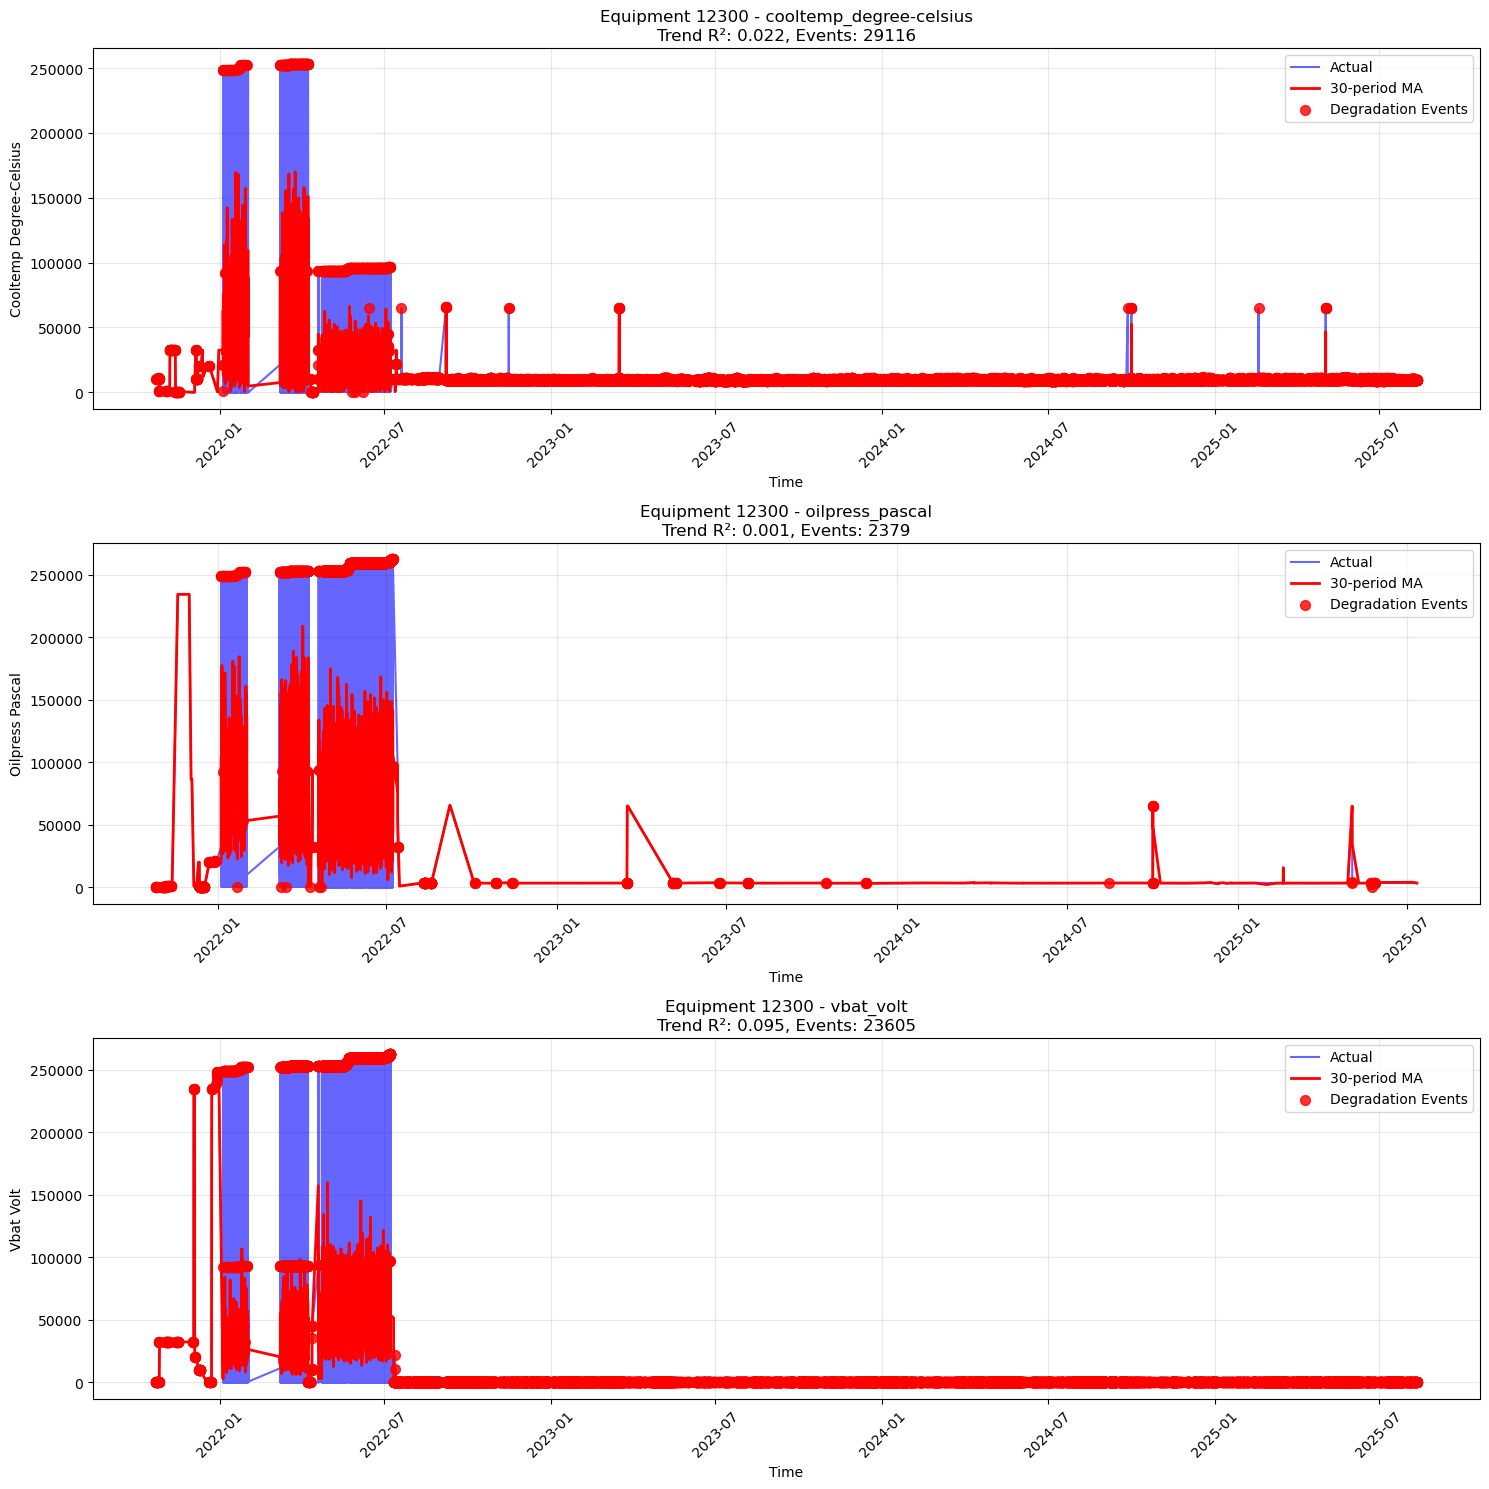

Degradation analysis complete!


In [36]:
print("\nSTEP 2: EQUIPMENT DEGRADATION ANALYSIS")
print("-" * 60)

equipment_id = df_clean['air'].iloc[0]  # Get the air ID
print(f"Analyzing equipment ID: {equipment_id}")

def analyze_single_equipment_degradation(data, sensor_cols):
    """Simplified degradation analysis for single equipment"""
    eq_data = data.sort_values('time').copy()
    
    degradation_results = {}
    
    for sensor in sensor_cols:
        if sensor not in eq_data.columns or eq_data[sensor].isna().all():
            continue
        
        sensor_data = eq_data[sensor].dropna()
        if len(sensor_data) < 10:
            continue
        
        # Calculating degradation metrics
        x = np.arange(len(sensor_data))
        y = sensor_data.values
        
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            # Rolling statistics for degradation detection
            eq_data[f'{sensor}_rolling_mean_30'] = eq_data[sensor].rolling(30, min_periods=5).mean()
            eq_data[f'{sensor}_rolling_std_30'] = eq_data[sensor].rolling(30, min_periods=5).std()
            eq_data[f'{sensor}_degradation_score'] = (
                eq_data[sensor] - eq_data[f'{sensor}_rolling_mean_30']
            ) / (eq_data[f'{sensor}_rolling_std_30'] + 1e-6)  # Avoid division by zero
            
            # Counting degradation events (anomalies beyond 2 std devs)
            degradation_events = (eq_data[f'{sensor}_degradation_score'].abs() > 2).sum()
            
            degradation_results[sensor] = {
                'trend_slope': slope,
                'trend_r_squared': r_value**2,
                'trend_p_value': p_value,
                'degradation_events': degradation_events,
                'data_points': len(sensor_data),
                'sensor_data': eq_data[['time', sensor, f'{sensor}_rolling_mean_30', f'{sensor}_degradation_score']].copy()
            }
            
        except Exception as e:
            print(f"Warning: Could not analyze {sensor}: {e}")
            continue
    
    return eq_data, degradation_results

# Analyze degradation patterns
print("Analyzing degradation patterns...")
df_with_degradation, degradation_analysis = analyze_single_equipment_degradation(
    df_clean, SENSOR_COLS[:3]
)

print(f"\nDegradation Analysis Results for Air {equipment_id}:")
print("-" * 50)

for sensor, results in degradation_analysis.items():
    print(f"\n{sensor}:")
    print(f"  Trend slope: {results['trend_slope']:.6f}")
    print(f"  R-squared: {results['trend_r_squared']:.3f}")
    print(f"  Degradation events: {results['degradation_events']}")
    print(f"  Data points: {results['data_points']}")

if degradation_analysis:
    n_sensors = len(degradation_analysis)
    fig, axes = plt.subplots(n_sensors, 1, figsize=(15, 5*n_sensors))
    
    if n_sensors == 1:
        axes = [axes]
    
    for i, (sensor, results) in enumerate(degradation_analysis.items()):
        data = results['sensor_data'].dropna()
        
        if len(data) > 0:
            # Plot actual sensor values
            axes[i].plot(data['time'], data[sensor], alpha=0.6, label='Actual', color='blue')
            
            # Plot rolling mean
            axes[i].plot(data['time'], data[f'{sensor}_rolling_mean_30'], 
                        'r-', linewidth=2, label='30-period MA')
            
            # Highlight degradation events
            degradation_points = data[data[f'{sensor}_degradation_score'].abs() > 2]
            if len(degradation_points) > 0:
                axes[i].scatter(degradation_points['time'], degradation_points[sensor], 
                              color='red', s=50, alpha=0.8, label='Degradation Events', zorder=5)
            
            axes[i].set_title(f"Equipment {equipment_id} - {sensor}\n"
                            f"Trend R²: {results['trend_r_squared']:.3f}, Events: {results['degradation_events']}")
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel(sensor.replace('_', ' ').title())
            axes[i].legend()
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No degradation analysis could be performed - check data quality")

print("Degradation analysis complete!")

FAILURE PATTERN DETECTION

In [37]:
print("\nSTEP 3: ADVANCED FAILURE PATTERN DETECTION")
print("-" * 60)

def detect_anomalies_multimethod(data, sensor_cols):
    """Used 2 different anomaly detection methods"""
    data_numeric = data[sensor_cols].dropna()
    
    if len(data_numeric) < 50:
        return data.assign(
            isolation_anomaly=0,
            statistical_anomaly=0,
            combined_anomaly=0
        )
    
    # Method 1: Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    isolation_anomalies = iso_forest.fit_predict(data_numeric)
    
    # Method 2: Statistical Z-score
    z_scores = np.abs(stats.zscore(data_numeric, axis=0))
    statistical_anomalies = (z_scores > 3).any(axis=1).astype(int)
    statistical_anomalies = statistical_anomalies * 2 - 1  # Convert to -1, 1 format
    
    # Combine results
    data_clean = data.copy()
    data_clean['isolation_anomaly'] = 0
    data_clean['statistical_anomaly'] = 0
    
    data_clean.loc[data_numeric.index, 'isolation_anomaly'] = (isolation_anomalies == -1).astype(int)
    data_clean.loc[data_numeric.index, 'statistical_anomaly'] = (statistical_anomalies == -1).astype(int)
    
    # Combined anomaly score
    data_clean['combined_anomaly'] = (
        data_clean['isolation_anomaly'] + data_clean['statistical_anomaly']
    )
    
    return data_clean

df_anomalies = detect_anomalies_multimethod(df_clean, SENSOR_COLS)

anomaly_summary = df_anomalies.groupby('air').agg({
    'isolation_anomaly': 'sum',
    'statistical_anomaly': 'sum',
    'combined_anomaly': 'sum'
}).reset_index()

print("\nAnomaly Detection Summary:")
print(f"Total isolation anomalies: {df_anomalies['isolation_anomaly'].sum()}")
print(f"Total statistical anomalies: {df_anomalies['statistical_anomaly'].sum()}")
print(f"Equipment with most anomalies:")
print(anomaly_summary.nlargest(5, 'combined_anomaly'))


STEP 3: ADVANCED FAILURE PATTERN DETECTION
------------------------------------------------------------

Anomaly Detection Summary:
Total isolation anomalies: 434
Total statistical anomalies: 4026
Equipment with most anomalies:
     air  isolation_anomaly  statistical_anomaly  combined_anomaly
0  12300                434                 4026              4460


TIME SERIES DECOMPOSITION AND STATIONARITY 


STEP 4: TIME SERIES DECOMPOSITION & STATIONARITY ANALYSIS
------------------------------------------------------------


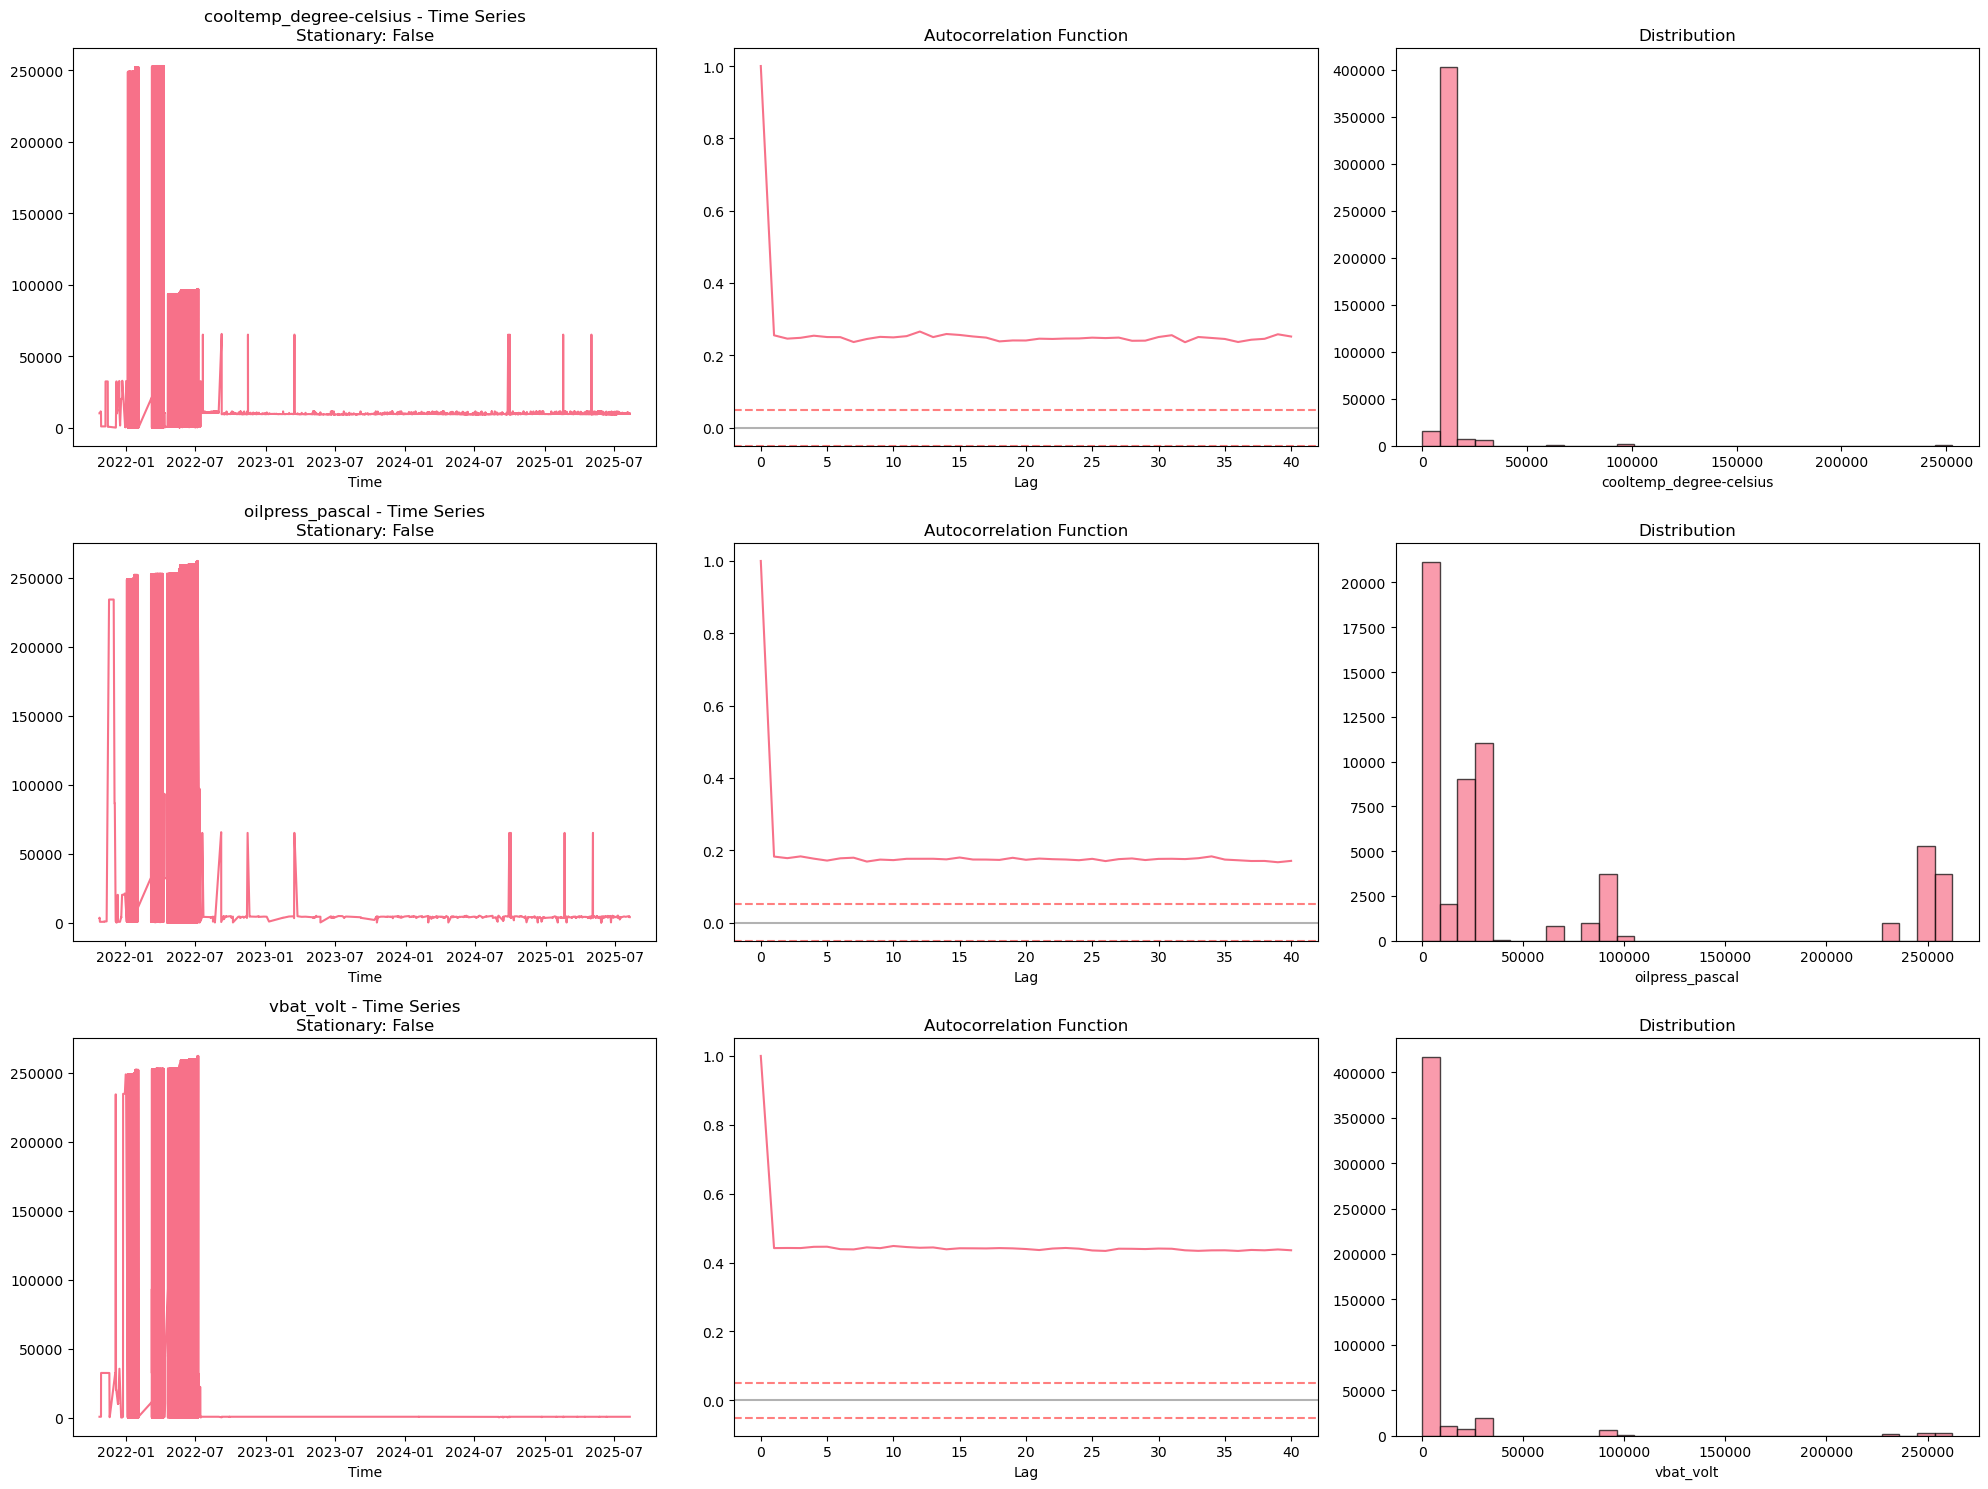

In [38]:
print("\nSTEP 4: TIME SERIES DECOMPOSITION & STATIONARITY ANALYSIS")
print("-" * 60)

def analyze_time_series_properties(data, sensor_col, equipment_id=None):  # method for time series analysis
    if equipment_id:
        ts_data = data[data['air'] == equipment_id].copy()
    else:
        ts_data = data.copy()
    
    ts_data = ts_data.sort_values('time').dropna(subset=[sensor_col])
    
    if len(ts_data) < 100:
        return None
    
    ts_data = ts_data.set_index('time')
    series = ts_data[sensor_col]
    
    # Stationarity testing
    adf_stat, adf_p, *_ = adfuller(series)
    kpss_stat, kpss_p, *_ = kpss(series)
    
    # Autocorrelation
    autocorr = acf(series, nlags=min(40, len(series)//4))
    
    results = {
        'sensor': sensor_col,
        'equipment_id': equipment_id,
        'adf_statistic': adf_stat,
        'adf_p_value': adf_p,
        'kpss_statistic': kpss_stat,
        'kpss_p_value': kpss_p,
        'is_stationary': (adf_p < 0.05) and (kpss_p > 0.05),
        'autocorrelation': autocorr,
        'series': series
    }
    
    return results

# Analyzing time series properties for the key sensors
ts_results = []
sample_equipment = df_clean['air'].iloc[0]

for sensor in SENSOR_COLS[:3]:
    result = analyze_time_series_properties(df_clean, sensor, sample_equipment)
    if result:
        ts_results.append(result)

# Visualizing the time series properties
fig, axes = plt.subplots(len(ts_results), 3, figsize=(20, 5*len(ts_results)))
if len(ts_results) == 1:
    axes = axes.reshape(1, -1)

for i, result in enumerate(ts_results):
    # Original
    axes[i, 0].plot(result['series'])
    axes[i, 0].set_title(f"{result['sensor']} - Time Series\n"
                        f"Stationary: {result['is_stationary']}")
    axes[i, 0].set_xlabel('Time')
    
    # Autocorrelation
    axes[i, 1].plot(result['autocorrelation'])
    axes[i, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[i, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.5)
    axes[i, 1].axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
    axes[i, 1].set_title('Autocorrelation Function')
    axes[i, 1].set_xlabel('Lag')
    
    # Distribution
    axes[i, 2].hist(result['series'], bins=30, alpha=0.7, edgecolor='black')
    axes[i, 2].set_title('Distribution')
    axes[i, 2].set_xlabel(result['sensor'])

plt.tight_layout()
plt.show()

MAINTENANCE EVENT TIMELINE ANALYSIS


STEP 5: MAINTENANCE EVENT TIMELINE ANALYSIS
------------------------------------------------------------
Analyzing maintenance event patterns...
Equipment 12300: 2955 maintenance events detected


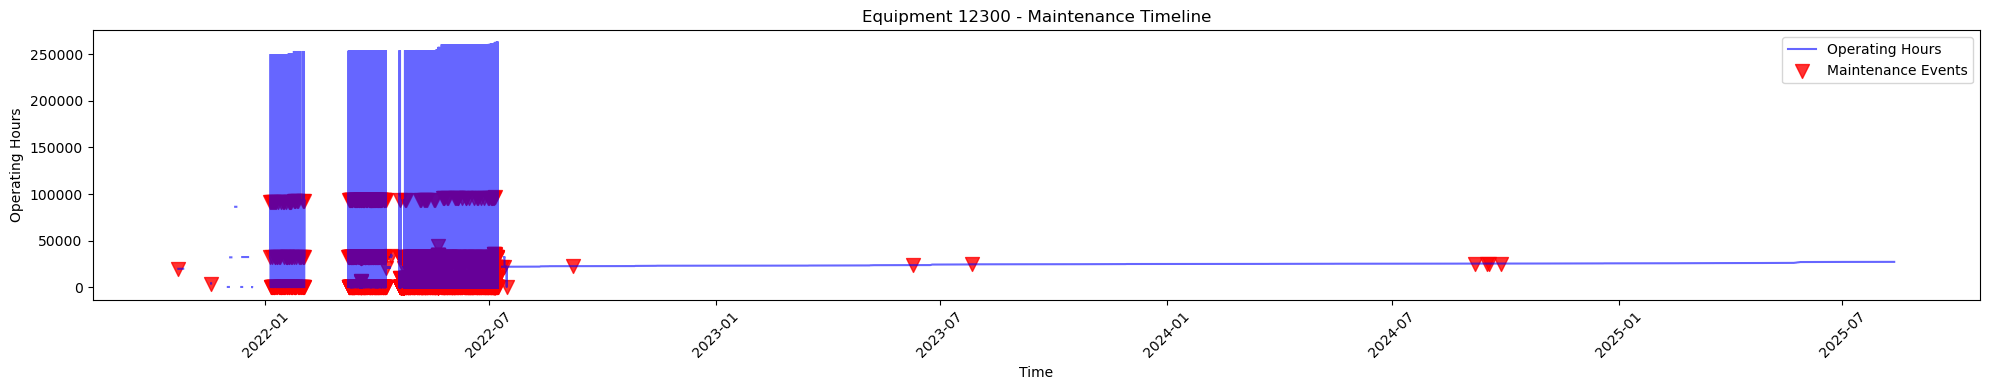

In [39]:
print("\nSTEP 5: MAINTENANCE EVENT TIMELINE ANALYSIS") # Detects maintenance needs based on sudden changes in operating hours, periods of inactivity, and reset patterns in sensors.
print("-" * 60)

def detect_maintenance_events(data, equipment_id):
    """Detect potential maintenance events based on operational patterns"""
    eq_data = data[data['air'] == equipment_id].copy().sort_values('time')
    
    if len(eq_data) < 50:
        return eq_data.assign(maintenance_event=0)
    
    eq_data['hours_diff'] = eq_data['hours_hour'].diff()
    eq_data['time_gap'] = eq_data['time'].diff().dt.total_seconds() / 3600  # in hours
    
    # Maintenance indicators
    eq_data['maintenance_event'] = 0
    
    # Large time gaps (equipment might be offline)
    if 'time_gap' in eq_data.columns:
        eq_data.loc[eq_data['time_gap'] > 24, 'maintenance_event'] = 1
    
    # Operating hours reset or large jumps
    if 'hours_diff' in eq_data.columns:
        hours_reset = eq_data['hours_diff'] < -100
        eq_data.loc[hours_reset, 'maintenance_event'] = 1
    
    return eq_data

# Analyzing maintenance patterns
print("Analyzing maintenance event patterns...")
maintenance_data = []

for eq_id in equipment_ids[:3]:  # Analyze first 3 equipment
    eq_maintenance = detect_maintenance_events(df_clean, eq_id)
    maintenance_data.append(eq_maintenance)
    
    maintenance_events = eq_maintenance[eq_maintenance['maintenance_event'] == 1]
    print(f"Equipment {eq_id}: {len(maintenance_events)} maintenance events detected")

# Visualizing maintenance timeline
fig, axes = plt.subplots(len(maintenance_data), 1, figsize=(20, 4*len(maintenance_data)))
if len(maintenance_data) == 1:
    axes = [axes]

for i, eq_data in enumerate(maintenance_data):
    ax = axes[i]
    
    ax.plot(eq_data['time'], eq_data['hours_hour'], 'b-', alpha=0.6, label='Operating Hours')
    
    # This highlights maintenance events
    maintenance_events = eq_data[eq_data['maintenance_event'] == 1]
    if len(maintenance_events) > 0:
        ax.scatter(maintenance_events['time'], maintenance_events['hours_hour'], 
                  color='red', s=100, alpha=0.8, label='Maintenance Events', marker='v')
    
    ax.set_title(f"Equipment {eq_data['air'].iloc[0]} - Maintenance Timeline")
    ax.set_xlabel('Time')
    ax.set_ylabel('Operating Hours')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

REMAINING USEFUL LIFE (RUL) ANALYSIS


STEP 6: REMAINING USEFUL LIFE (RUL) ANALYSIS
------------------------------------------------------------


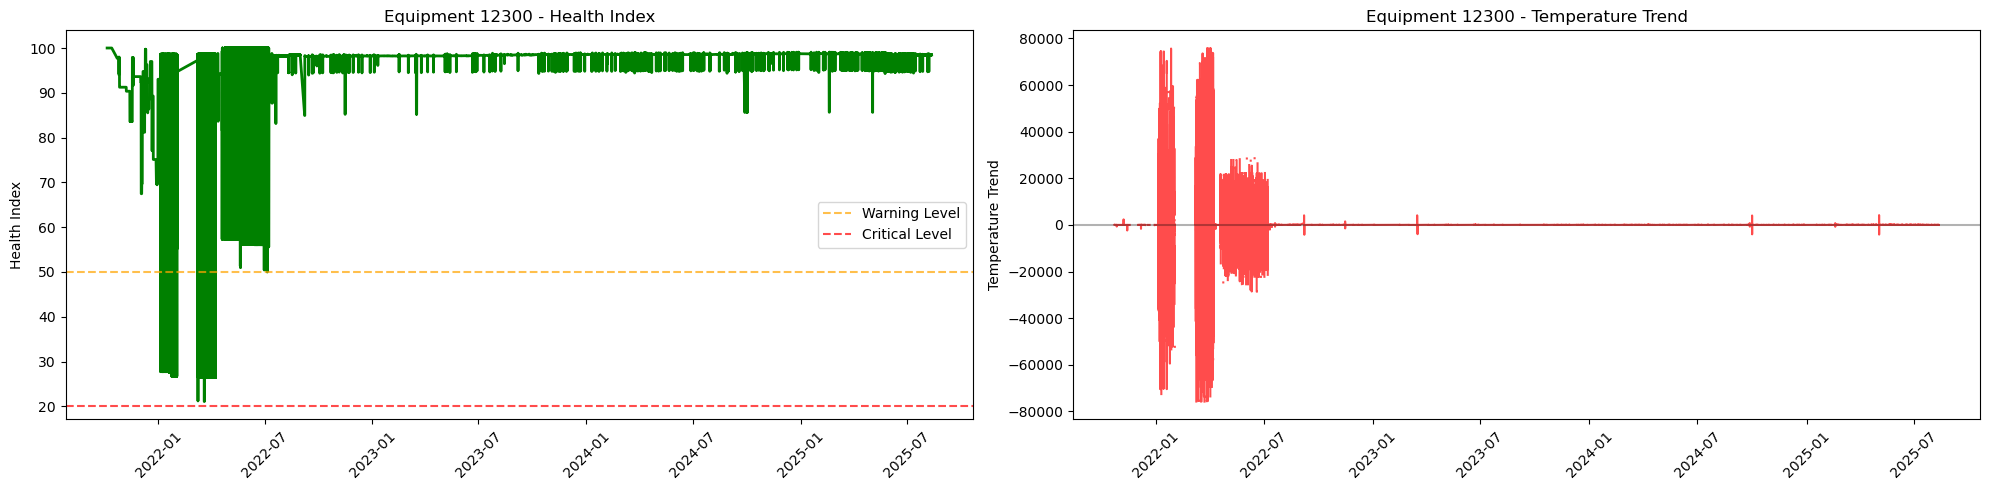

In [40]:
print("\nSTEP 6: REMAINING USEFUL LIFE (RUL) ANALYSIS")
print("-" * 60)

def calculate_rul_features(data, equipment_id):
    eq_data = data[data['air'] == equipment_id].copy().sort_values('time')
    
    if len(eq_data) < 30:
        return None
    
    # Calculating degradation indicators
    for sensor in SENSOR_COLS:
        if sensor not in eq_data.columns:
            continue
            
        # Robust trend analysis
        def safe_trend_calculation(x):
            try:
                # Removing NaN values and checking for sufficient data
                x_clean = x.dropna()
                if len(x_clean) < 2:
                    return 0.0
                
                # Checks for constant values
                if x_clean.std() < 1e-10:
                    return 0.0
                
                # Use polyfit with error handling
                slope = np.polyfit(range(len(x_clean)), x_clean, 1)[0]
                return slope if not np.isnan(slope) else 0.0
                
            except (np.linalg.LinAlgError, ValueError):
                return 0.0
        
        eq_data[f'{sensor}_trend'] = eq_data[sensor].rolling(20, min_periods=5).apply(
            safe_trend_calculation, raw=False
        )
        
        # Variability increase (often happens before failure)
        eq_data[f'{sensor}_variability'] = eq_data[sensor].rolling(15, min_periods=5).std()
        
        # distance from normal operation
        sensor_clean = eq_data[sensor].dropna()
        if len(sensor_clean) > 10 and sensor_clean.std() > 0:
            sensor_mean = sensor_clean.mean()
            sensor_std = sensor_clean.std()
            eq_data[f'{sensor}_deviation'] = np.abs(eq_data[sensor] - sensor_mean) / sensor_std
        else:
            eq_data[f'{sensor}_deviation'] = 0
    
    # Calculates the health index (0-100, where 100 is healthy)
    health_indicators = [col for col in eq_data.columns if '_deviation' in col]
    if health_indicators:
        deviation_means = eq_data[health_indicators].fillna(0).mean(axis=1)
        eq_data['health_index'] = np.clip(100 - deviation_means * 20, 0, 100)
    else:
        eq_data['health_index'] = 100
    
    return eq_data

# Calculate RUL 
rul_data = []

equipment_ids = df_clean['air'].unique()

for eq_id in equipment_ids[:3]:
    eq_rul = calculate_rul_features(df_clean, eq_id)
    if eq_rul is not None:
        rul_data.append(eq_rul)

# To show health degradation
fig, axes = plt.subplots(len(rul_data), 2, figsize=(20, 5*len(rul_data)))
if len(rul_data) == 1:
    axes = axes.reshape(1, -1)

for i, eq_data in enumerate(rul_data):
    eq_id = eq_data['air'].iloc[0]
    
    # Health index over time
    if 'health_index' in eq_data.columns:
        axes[i, 0].plot(eq_data['time'], eq_data['health_index'], 'g-', linewidth=2)
        axes[i, 0].axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Warning Level')
        axes[i, 0].axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Critical Level')
        axes[i, 0].set_title(f"Equipment {eq_id} - Health Index")
        axes[i, 0].set_ylabel('Health Index')
        axes[i, 0].legend()
    
    # trend analysis on the sensor
    temp_trend_col = 'cooltemp_degree-celsius_trend'
    if temp_trend_col in eq_data.columns:
        axes[i, 1].plot(eq_data['time'], eq_data[temp_trend_col], 'r-', alpha=0.7)
        axes[i, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[i, 1].set_title(f"Equipment {eq_id} - Temperature Trend")
        axes[i, 1].set_ylabel('Temperature Trend')

for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

FEATURE ENGINEERING FOR CNN-LSTM

In [ ]:
print("\nSTEP 7: FEATURE ENGINEERING FOR CNN-LSTM")
print("-" * 60)

def create_advanced_features(data, window_sizes=[5, 10, 20, 50]): # method for creating advanced features for the CNN-LSTM model
    feature_data = data.copy()
    
    # group by equipment for proper time series feature engineering
    for eq_id in data['air'].unique():
        eq_mask = feature_data['air'] == eq_id
        eq_data = feature_data[eq_mask].sort_values('time')
        
        for sensor in SENSOR_COLS:
            if sensor not in eq_data.columns:
                continue
                
            # Rolling statistics
            for window in window_sizes:
                # Basic 
                feature_data.loc[eq_mask, f'{sensor}_rolling_mean_{window}'] = \
                    eq_data[sensor].rolling(window, min_periods=1).mean().values
                feature_data.loc[eq_mask, f'{sensor}_rolling_std_{window}'] = \
                    eq_data[sensor].rolling(window, min_periods=1).std().values
                feature_data.loc[eq_mask, f'{sensor}_rolling_min_{window}'] = \
                    eq_data[sensor].rolling(window, min_periods=1).min().values
                feature_data.loc[eq_mask, f'{sensor}_rolling_max_{window}'] = \
                    eq_data[sensor].rolling(window, min_periods=1).max().values
                
                # more advanced 
                feature_data.loc[eq_mask, f'{sensor}_rolling_skew_{window}'] = \
                    eq_data[sensor].rolling(window, min_periods=3).skew().values
                feature_data.loc[eq_mask, f'{sensor}_rolling_kurt_{window}'] = \
                    eq_data[sensor].rolling(window, min_periods=3).kurt().values
            
            # Lag features
            for lag in [1, 3, 5, 10]:
                feature_data.loc[eq_mask, f'{sensor}_lag_{lag}'] = \
                    eq_data[sensor].shift(lag).values
            
            # Rate of change
            feature_data.loc[eq_mask, f'{sensor}_rate_of_change'] = \
                eq_data[sensor].pct_change().values
            
            # Exponential moving average
            feature_data.loc[eq_mask, f'{sensor}_ema_10'] = \
                eq_data[sensor].ewm(span=10).mean().values
    
    return feature_data

print("Creating features...")
df_features = create_advanced_features(df_clean)

# Feature importance analysis using correlation with anomalies
feature_cols = [col for col in df_features.columns if any(
    pattern in col for pattern in ['rolling_', 'lag_', 'rate_of_change', 'ema_']
)]

if 'combined_anomaly' in df_anomalies.columns:
    df_features['target'] = df_anomalies['combined_anomaly']
    
    correlations = []
    for col in feature_cols[:20]:  # Analyze top 20 features
        if col in df_features.columns:
            corr = df_features[col].corr(df_features['target'])
            if not np.isnan(corr):
                correlations.append((col, abs(corr)))
    
    # Sort by correlation strength
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 features by correlation with anomalies:")
    for i, (feature, corr) in enumerate(correlations[:10]):
        print(f"{i+1:2d}. {feature}: {corr:.4f}")

print(f"\nFinal feature set shape: {df_features.shape}")
print(f"Total engineered features: {len(feature_cols)}")


STEP 7: FEATURE ENGINEERING FOR CNN-LSTM
------------------------------------------------------------
Creating advanced features...

Top 10 features by correlation with anomalies:
 1. cooltemp_degree-celsius_rolling_skew_5: 0.0267
 2. cooltemp_degree-celsius_rolling_skew_10: 0.0263
 3. cooltemp_degree-celsius_rolling_std_50: 0.0244
 4. cooltemp_degree-celsius_rolling_std_20: 0.0218
 5. cooltemp_degree-celsius_rolling_min_20: 0.0213
 6. cooltemp_degree-celsius_rolling_mean_50: 0.0184
 7. cooltemp_degree-celsius_rolling_max_20: 0.0170
 8. cooltemp_degree-celsius_rolling_std_10: 0.0163
 9. cooltemp_degree-celsius_rolling_mean_20: 0.0151
10. cooltemp_degree-celsius_rolling_max_10: 0.0117

Final feature set shape: (509084, 214)
Total engineered features: 180
